In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import plot_model
import scipy.stats as stats
import os 
import h5py
import sys
import re
import xgboost as xgb 
import sklearn.multioutput

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'divmax', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 2.2737367544323206e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


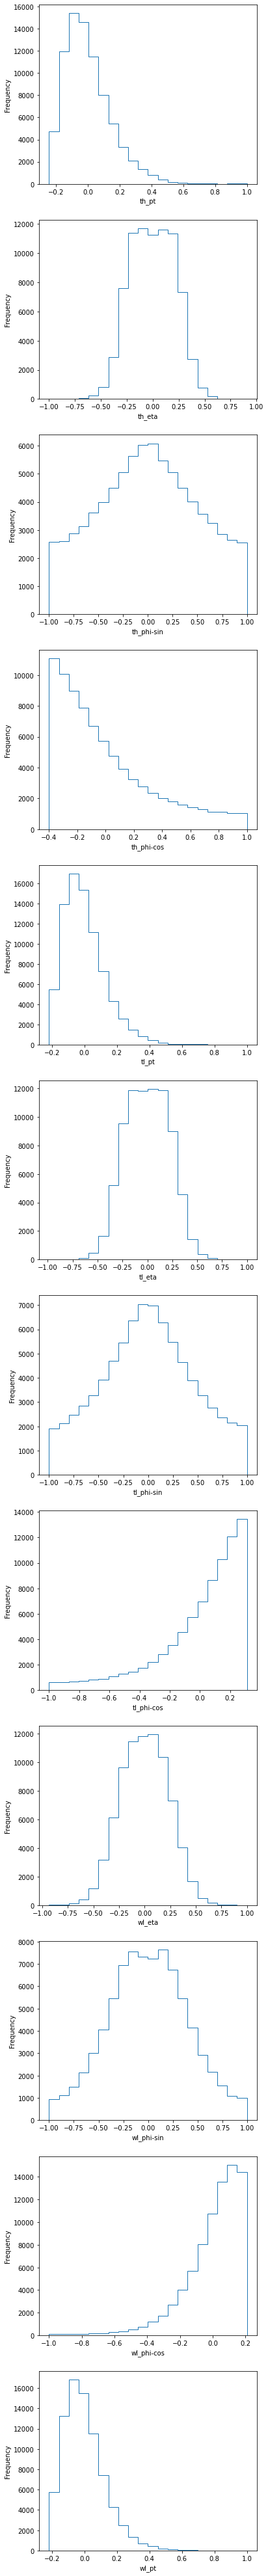

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

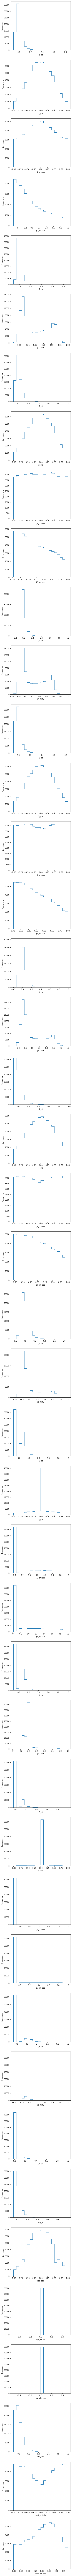

In [5]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(X_names)]),
        layers.BatchNormalization(),
        layers.Dense(256,  activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256,  activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256,  activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(len(Y_names),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23040     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6

In [21]:
# Fit model

Epochs= 512

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False,
                   batch_size=512)


Train on 64000 samples, validate on 16000 samples
Epoch 1/512
64000/64000 [==============================] - 1s 20us/sample - loss: 1.4907 - mse: 1.4827 - val_loss: 1.5147 - val_mse: 1.5066
Epoch 2/512
64000/64000 [==============================] - 1s 20us/sample - loss: 1.4605 - mse: 1.4524 - val_loss: 1.4862 - val_mse: 1.4781
Epoch 3/512
64000/64000 [==============================] - 1s 19us/sample - loss: 1.4314 - mse: 1.4233 - val_loss: 1.4587 - val_mse: 1.4506
Epoch 4/512
64000/64000 [==============================] - 1s 19us/sample - loss: 1.4034 - mse: 1.3953 - val_loss: 1.4321 - val_mse: 1.4240
Epoch 5/512
64000/64000 [==============================] - 1s 18us/sample - loss: 1.3764 - mse: 1.3684 - val_loss: 1.4064 - val_mse: 1.3983
Epoch 6/512
64000/64000 [==============================] - 1s 20us/sample - loss: 1.3504 - mse: 1.3423 - val_loss: 1.3815 - val_mse: 1.3735
Epoch 7/512
64000/64000 [==============================] - 1s 19us/sample - loss: 1.3252 - mse: 1.3172 - val_l

Epoch 59/512
64000/64000 [==============================] - 1s 18us/sample - loss: 0.5857 - mse: 0.5777 - val_loss: 0.6138 - val_mse: 0.6058
Epoch 60/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.5773 - mse: 0.5693 - val_loss: 0.6050 - val_mse: 0.5970
Epoch 61/512
64000/64000 [==============================] - 1s 18us/sample - loss: 0.5690 - mse: 0.5610 - val_loss: 0.5964 - val_mse: 0.5884
Epoch 62/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.5609 - mse: 0.5529 - val_loss: 0.5879 - val_mse: 0.5799
Epoch 63/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.5528 - mse: 0.5449 - val_loss: 0.5795 - val_mse: 0.5715
Epoch 64/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.5449 - mse: 0.5370 - val_loss: 0.5713 - val_mse: 0.5633
Epoch 65/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.5371 - mse: 0.5292 - val_loss: 0.5631 - val_mse: 0.5552
Epoch 66/512


Epoch 117/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2639 - mse: 0.2560 - val_loss: 0.2751 - val_mse: 0.2672
Epoch 118/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2606 - mse: 0.2527 - val_loss: 0.2717 - val_mse: 0.2638
Epoch 119/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2574 - mse: 0.2495 - val_loss: 0.2683 - val_mse: 0.2604
Epoch 120/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2542 - mse: 0.2463 - val_loss: 0.2649 - val_mse: 0.2570
Epoch 121/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2511 - mse: 0.2432 - val_loss: 0.2616 - val_mse: 0.2537
Epoch 122/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2481 - mse: 0.2402 - val_loss: 0.2584 - val_mse: 0.2505
Epoch 123/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.2450 - mse: 0.2371 - val_loss: 0.2552 - val_mse: 0.2473
Epoch 

Epoch 175/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.1429 - mse: 0.1351 - val_loss: 0.1472 - val_mse: 0.1394
Epoch 176/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.1418 - mse: 0.1339 - val_loss: 0.1460 - val_mse: 0.1381
Epoch 177/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.1406 - mse: 0.1328 - val_loss: 0.1447 - val_mse: 0.1369
Epoch 178/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.1395 - mse: 0.1316 - val_loss: 0.1435 - val_mse: 0.1357
Epoch 179/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.1383 - mse: 0.1305 - val_loss: 0.1423 - val_mse: 0.1345
Epoch 180/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.1372 - mse: 0.1294 - val_loss: 0.1412 - val_mse: 0.1334
Epoch 181/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.1362 - mse: 0.1283 - val_loss: 0.1400 - val_mse: 0.1322
Epoch 

Epoch 233/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.1000 - mse: 0.0923 - val_loss: 0.1023 - val_mse: 0.0945
Epoch 234/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0996 - mse: 0.0919 - val_loss: 0.1018 - val_mse: 0.0941
Epoch 235/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0992 - mse: 0.0914 - val_loss: 0.1014 - val_mse: 0.0937
Epoch 236/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.0987 - mse: 0.0910 - val_loss: 0.1010 - val_mse: 0.0933
Epoch 237/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.0983 - mse: 0.0906 - val_loss: 0.1006 - val_mse: 0.0928
Epoch 238/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0979 - mse: 0.0902 - val_loss: 0.1001 - val_mse: 0.0924
Epoch 239/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0976 - mse: 0.0899 - val_loss: 0.0997 - val_mse: 0.0920
Epoch 

Epoch 291/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0835 - mse: 0.0760 - val_loss: 0.0855 - val_mse: 0.0779
Epoch 292/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0834 - mse: 0.0758 - val_loss: 0.0853 - val_mse: 0.0777
Epoch 293/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0832 - mse: 0.0756 - val_loss: 0.0851 - val_mse: 0.0776
Epoch 294/512
64000/64000 [==============================] - 1s 18us/sample - loss: 0.0830 - mse: 0.0754 - val_loss: 0.0849 - val_mse: 0.0774
Epoch 295/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0828 - mse: 0.0753 - val_loss: 0.0848 - val_mse: 0.0772
Epoch 296/512
64000/64000 [==============================] - 1s 18us/sample - loss: 0.0826 - mse: 0.0751 - val_loss: 0.0846 - val_mse: 0.0770
Epoch 297/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0825 - mse: 0.0749 - val_loss: 0.0844 - val_mse: 0.0769
Epoch 

Epoch 349/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.0757 - mse: 0.0682 - val_loss: 0.0778 - val_mse: 0.0704
Epoch 350/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0756 - mse: 0.0682 - val_loss: 0.0777 - val_mse: 0.0703
Epoch 351/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.0755 - mse: 0.0681 - val_loss: 0.0776 - val_mse: 0.0702
Epoch 352/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0754 - mse: 0.0680 - val_loss: 0.0775 - val_mse: 0.0701
Epoch 353/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0753 - mse: 0.0679 - val_loss: 0.0774 - val_mse: 0.0700
Epoch 354/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.0752 - mse: 0.0678 - val_loss: 0.0773 - val_mse: 0.0699
Epoch 355/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0751 - mse: 0.0677 - val_loss: 0.0772 - val_mse: 0.0698
Epoch 

Epoch 407/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0710 - mse: 0.0637 - val_loss: 0.0734 - val_mse: 0.0661
Epoch 408/512
64000/64000 [==============================] - 1s 20us/sample - loss: 0.0709 - mse: 0.0636 - val_loss: 0.0733 - val_mse: 0.0661
Epoch 409/512
64000/64000 [==============================] - 1s 18us/sample - loss: 0.0708 - mse: 0.0636 - val_loss: 0.0733 - val_mse: 0.0660
Epoch 410/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0708 - mse: 0.0635 - val_loss: 0.0732 - val_mse: 0.0660
Epoch 411/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0707 - mse: 0.0634 - val_loss: 0.0732 - val_mse: 0.0659
Epoch 412/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0706 - mse: 0.0634 - val_loss: 0.0731 - val_mse: 0.0658
Epoch 413/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0706 - mse: 0.0633 - val_loss: 0.0730 - val_mse: 0.0658
Epoch 

Epoch 465/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0676 - mse: 0.0605 - val_loss: 0.0705 - val_mse: 0.0634
Epoch 466/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0676 - mse: 0.0605 - val_loss: 0.0705 - val_mse: 0.0634
Epoch 467/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0676 - mse: 0.0605 - val_loss: 0.0704 - val_mse: 0.0633
Epoch 468/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0675 - mse: 0.0604 - val_loss: 0.0704 - val_mse: 0.0633
Epoch 469/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0675 - mse: 0.0604 - val_loss: 0.0703 - val_mse: 0.0633
Epoch 470/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0674 - mse: 0.0603 - val_loss: 0.0703 - val_mse: 0.0632
Epoch 471/512
64000/64000 [==============================] - 1s 19us/sample - loss: 0.0674 - mse: 0.0603 - val_loss: 0.0703 - val_mse: 0.0632
Epoch 

Text(0.5, 1.0, 'MSE loss')

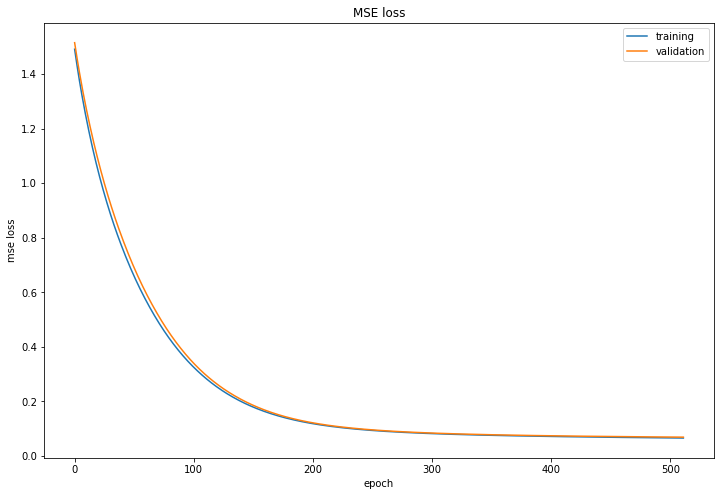

In [22]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [23]:
predictions = model.predict(testX)

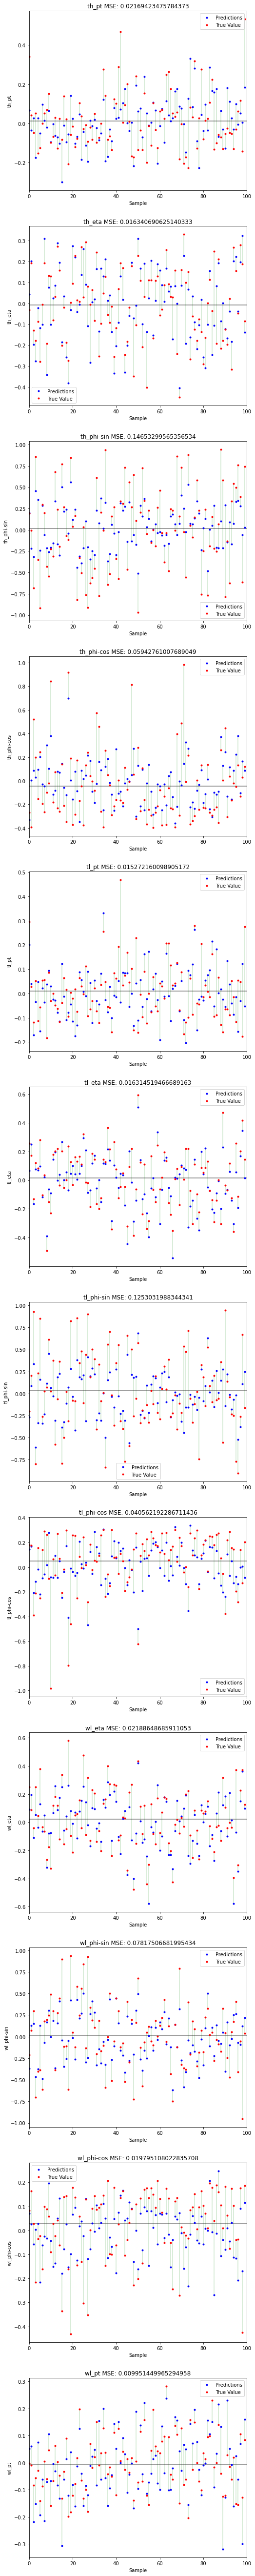

In [24]:

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
Y_small = trainY[0:100,:]


def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*len(Y_names)))
    for i in range(0,len(Y_names)):
        plt.subplot(len(Y_names),1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Sample')
        plt.ylabel(Y_names[i])
        plt.xlim(0, crop)
        plt.title(Y_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [25]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(Y_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_names[i]), '%.10f'%MSE)

total MSE: 0.06228107762508119
th_pt MSE :  0.0204409685
th_eta MSE :  0.0248588451
th_phi-sin MSE :  0.1991363153
th_phi-cos MSE :  0.0929623966
tl_pt MSE :  0.0175322323
tl_eta MSE :  0.0215365816
tl_phi-sin MSE :  0.1566837781
tl_phi-cos MSE :  0.0639380606
wl_eta MSE :  0.0213097022


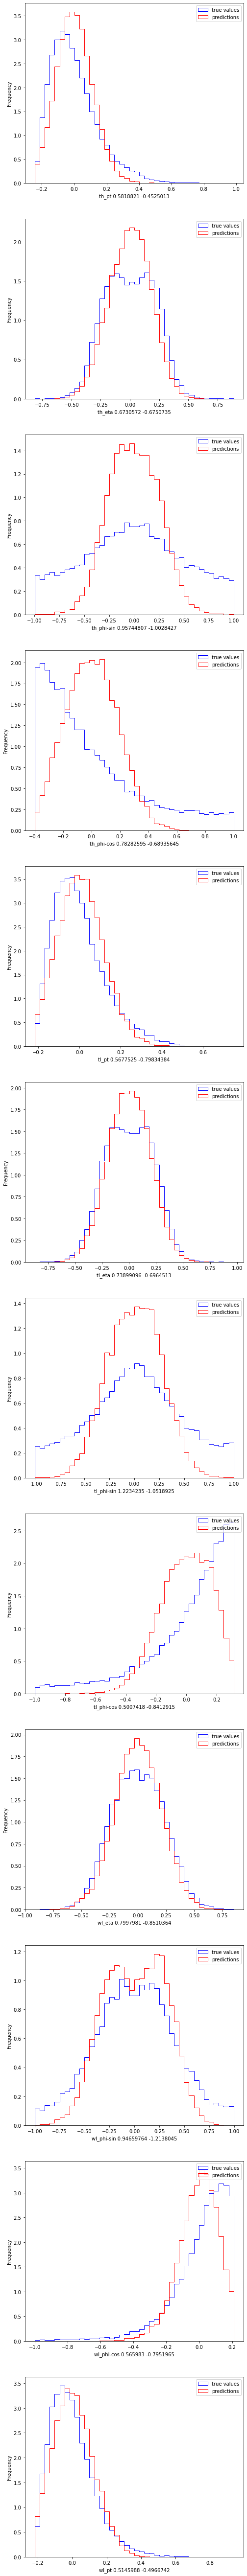

In [26]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

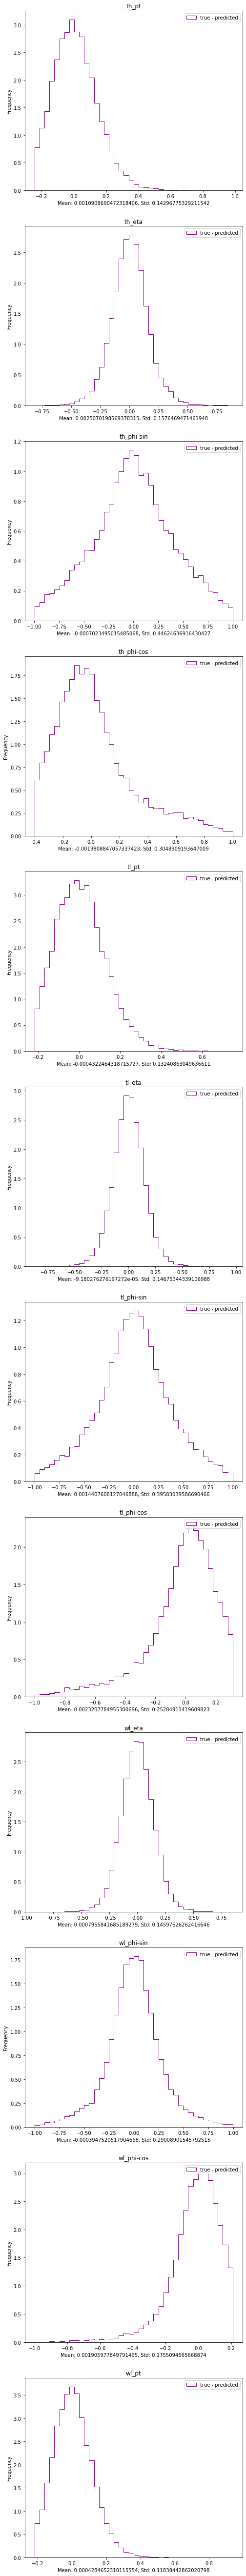

In [27]:
# True - Predicted 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_names[i])
    plt.legend()
    plt.ylabel('Frequency')

In [28]:
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
out_scaled = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

total_predictions = model.predict(X_total)
predict_scaled = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]

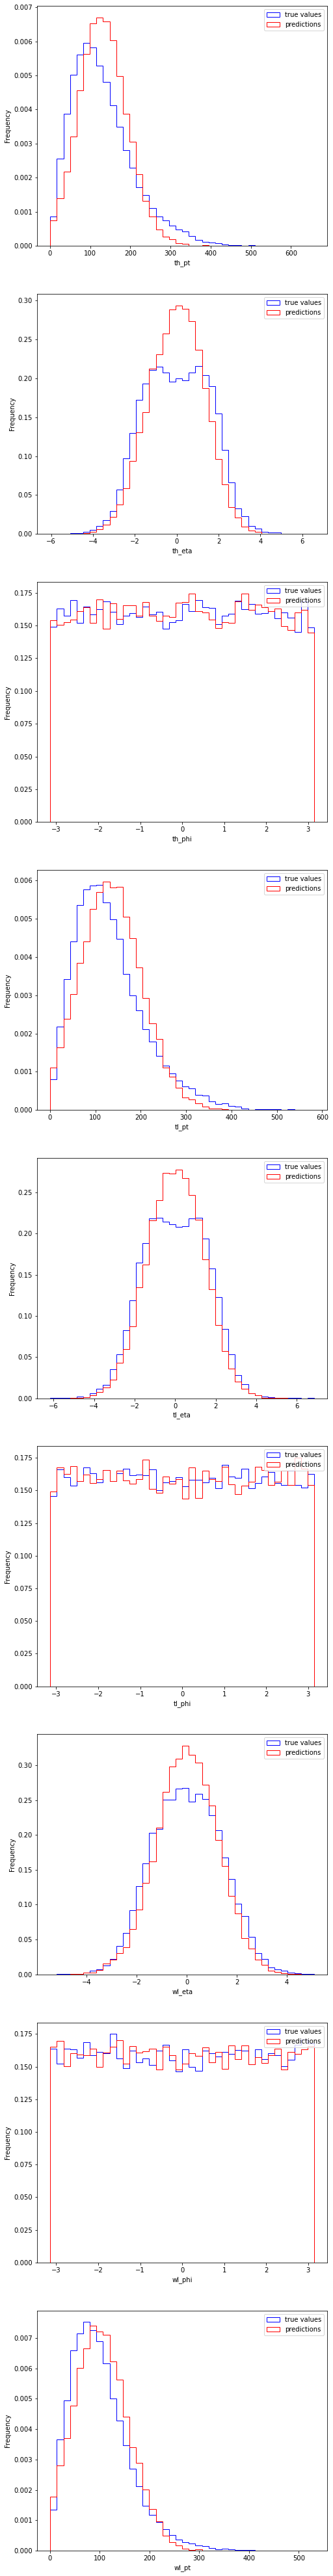

In [29]:
# Histograms to the original scale 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

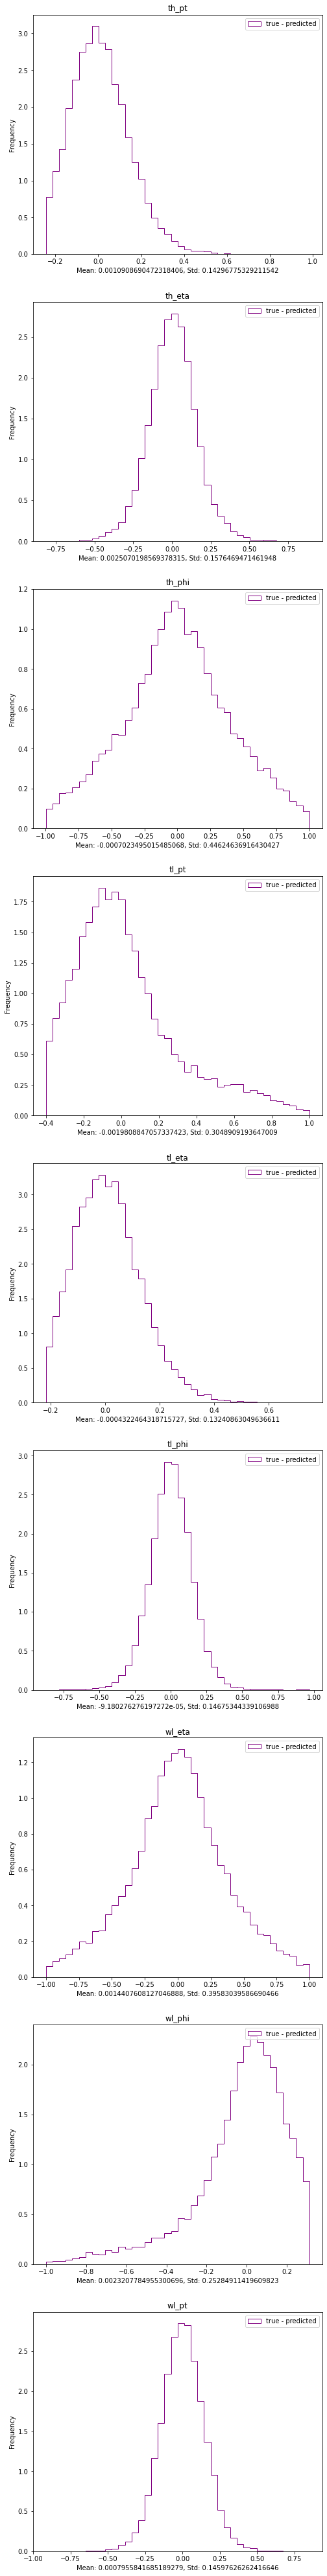

In [30]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

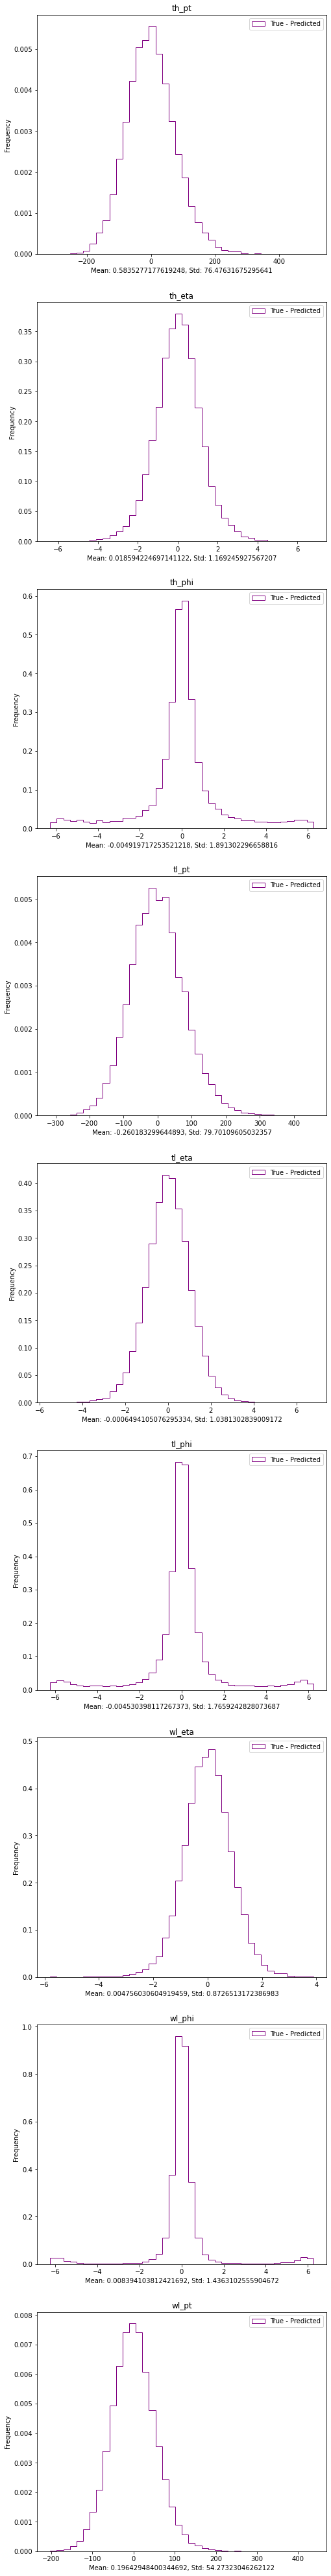

In [31]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [32]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  5848.9675286959
Original Scale th_eta MSE :  1.3674817843
Original Scale th_phi MSE :  1.1556777835
Original Scale tl_pt MSE :  6352.3324069723
Original Scale tl_eta MSE :  1.0777149081
Original Scale tl_phi MSE :  0.7961415358
Original Scale wl_eta MSE :  0.7615429413
Original Scale wl_phi MSE :  0.3088819498
Original Scale wl_pt MSE :  2945.6221293910


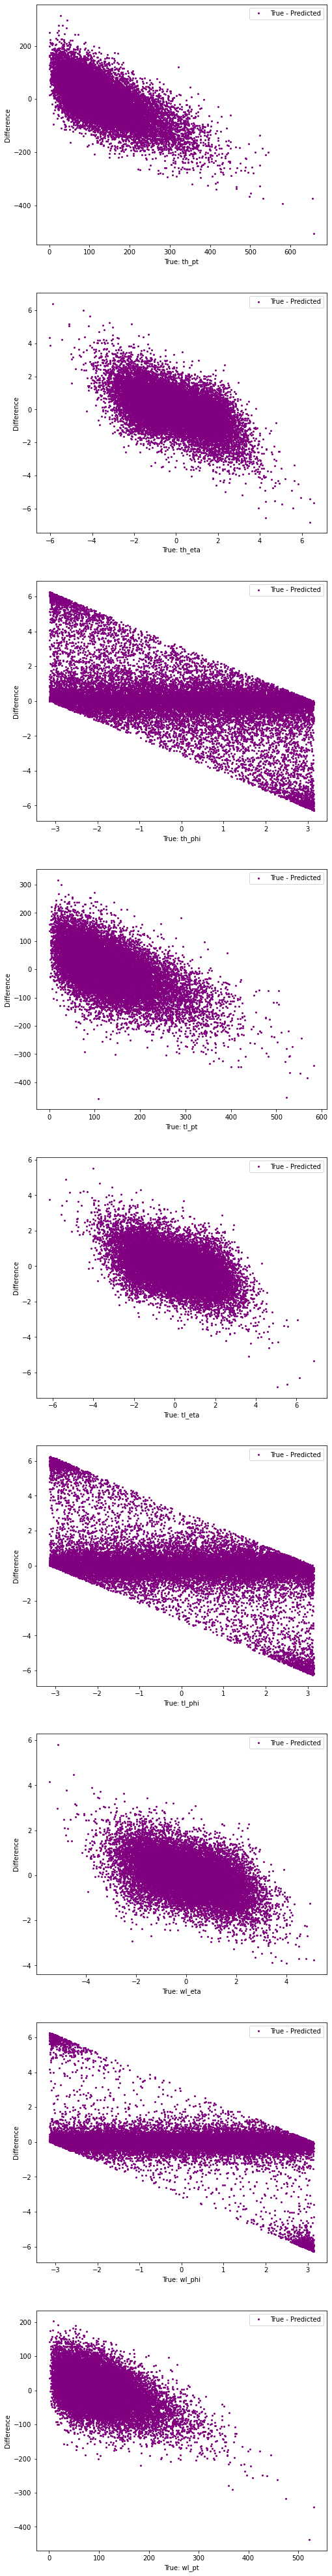

In [33]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')